## Welcome to Multi-Modal Rag Project 
### Author: Shiv Kalaria
#### Retrieve Text, Tables, Images 
#### LLM: GPT-4o and GPT-4-mini

In [37]:
%%capture
!pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib tiktoken watermark pymupdf
# !pip install langchain openai langchain-chroma
# !pip install chromadb

In [15]:
%%capture
!pip install tabula-py

!pip install :

* unstructured[all-docs] → Installs the Unstructured library with support for processing various document types (PDFs, Word, HTML, etc.).
* pillow → A popular image-processing library in Python.
* pydantic → A data validation and settings management library (often used in FastAPI and LangChain).
* lxml → A library for processing and parsing XML and HTML documents efficiently.
* matplotlib → A library for creating visualizations and plots.
* chromadb → A vector database used for storing and retrieving embeddings (useful in AI applications like RAG).
* tiktoken → A tokenizer library used to count tokens in text (used for OpenAI models).
* watermark → A Jupyter Notebook extension that displays the versions of installed packages.

In [38]:
# %%capture
# !pip install poppler-utils tesseract-ocr  --> cann't do this as its system package

import os

# Set Poppler path in the environment variable (Windows)
os.environ["PATH"] += os.pathsep + r"<enter-your-path>poppler\poppler-24.08.0\Library\bin"  # Update with your Poppler path
os.environ["PATH"] += os.pathsep + r"<enter-your-path>\Tesseract-OCR"  # Update this with your Tesseract path

!pdftotext -v
!tesseract --version

pdftotext version 24.08.0
Copyright 2005-2024 The Poppler Developers - http://poppler.freedesktop.org
Copyright 1996-2011, 2022 Glyph & Cog, LLC


tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0


In [39]:
%load_ext watermark
%watermark -a "Shiv Kalaria" -vmp langchain,unstructured,openai

Author: Shiv Kalaria

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.32.0

langchain   : 0.3.19
unstructured: 0.17.2
openai      : 1.64.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [7]:
#to load from url to local pdf
from unstructured.partition.pdf import partition_pdf

pdf_file = "Documents/wildfire_stat.pdf"
img_output_dir = "Documents/multimodal_output/"

# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=pdf_file,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    strategy="hi_res",
    extract_tables=True,
    chunking_strategy=None,
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=img_output_dir
)



CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


partition_pdf(): Extracts structured data (text, tables, images) from a PDF.

Parameters:
* filename=pdf_file: Path to the PDF file to process.
* extract_images_in_pdf=True: Extracts and saves images from the PDF.
* infer_table_structure=True: Automatically detects and structures tables in the PDF.
* chunking_strategy="by_title": Splits text into chunks based on titles or headings.
* max_characters=4000: Maximum characters per text chunk (prevents oversized chunks).
* new_after_n_chars=3800: Starts a new chunk after 3800 characters.
* combine_text_under_n_chars=2000: Combines small chunks (under 2000 chars) with the next chunk.
* image_output_dir_path="": Directory to save extracted images.

In [8]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.Image'>": 5,
 "<class 'unstructured.documents.elements.NarrativeText'>": 20,
 "<class 'unstructured.documents.elements.Title'>": 14,
 "<class 'unstructured.documents.elements.FigureCaption'>": 6,
 "<class 'unstructured.documents.elements.Table'>": 2,
 "<class 'unstructured.documents.elements.Header'>": 1}

In [9]:
from pydantic import BaseModel
from typing import Any

class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.NarrativeText" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))
    elif "unstructured.documents.elements.Image" in str(type(element)):
        categorized_elements.append(Element(type="image", text=str(element)))
    elif "unstructured.documents.elements.Title" in str(type(element)):
        categorized_elements.append(Element(type="title", text=str(element)))
    elif "unstructured.documents.elements.FigureCaption" in str(type(element)):
        categorized_elements.append(Element(type="figureCaption", text=str(element)))
    elif "unstructured.documents.elements.Header" in str(type(element)):
        categorized_elements.append(Element(type="header", text=str(element)))





# Image
image_elements = [e for e in categorized_elements if e.type == "image"]
print("image: ", len(image_elements))
# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print("text: ", len(text_elements))
# Title
title_elements = [e for e in categorized_elements if e.type == "title"]
print("title: ", len(title_elements))
# Figure
figure_elements = [e for e in categorized_elements if e.type == "figureCaption"]
print("Figure: ", len(figure_elements))
# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print("table: ", len(table_elements))
# Header
header_elements = [e for e in categorized_elements if e.type == "header"]
print("header: ", len(header_elements))


image:  5
text:  20
title:  14
Figure:  6
table:  2
header:  1


In [6]:
table_elements[0]

Element(type='table', text='2018 2019 2020 Number of Fires (thousands) Federal 12.5 10.9 14.4 FS 5.6 5.3 6.7 DOI 7.0 5.3 7.6 2021 14.0 6.2 7.6 2022 11.7 5.9 5.8 Other 0.1 0.2 <0.1 0.2 0.1 Nonfederal 45.6 39.6 44.6 45.0 57.2 Total 58.1 50.5 59.0 59.0 69.0 Acres Burned (millions) Federal 4.6 3.1 7.1 5.2 4.0 FS 2.3 0.6 4.8 4.1 1.9 DOI 2.3 2.3 2.3 1.0 2.1 Other <0.1 <0.1 <0.1 <0.1 <0.1 Nonfederal 4.1 1.6 3.1 1.9 3.6 Total 8.8 4.7 10.1 7.1 7.6')

In [7]:
text_elements[1]

Element(type='text', text='Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.')

In [4]:
image_elements[0]

Element(type='image', text='a. aa = Informing the legislative debate since 1914 Congressional Research Service')

In [11]:
title_elements[0]

Element(type='title', text='Wildfire Statistics')

In [10]:
from unstructured.documents.elements import Image as UnstructuredImage
from PIL import Image as PILImage
import base64
import io
from IPython.display import display

# boolean variable to find images
image_found = False

# Loop through extracted elements to look for images
for idx, elem in enumerate(raw_pdf_elements):
    if isinstance(elem, UnstructuredImage):  # Checking in Image object
        image_found = True
        print(f"🔹 Found image at index {idx}")

        # Check if 'image' attribute exists and is not empty
        if hasattr(elem, 'image') and elem.image:
            try:
                print(f"✅ Image data found for element {idx}. Lets display...")

                # Decoding base64 image data
                image_data = base64.b64decode(elem.image)

                # Converting to an image object
                pil_image = PILImage.open(io.BytesIO(image_data))

                # Displaying the image
                display(pil_image)

            except Exception as e:
                print(f"⚠️ Unable to display image at index {idx}: {e}")
        else:
            print(f"⚠️ Image at index {idx} has no data.")
            
if not image_found:
    print("❌ No images found in raw_pdf_elements.")

print("---------Partition_pdf detects images - but has no data and unable to save--------------")

🔹 Found image at index 0
⚠️ Image at index 0 has no data.
🔹 Found image at index 5
⚠️ Image at index 5 has no data.
🔹 Found image at index 14
⚠️ Image at index 14 has no data.
🔹 Found image at index 27
⚠️ Image at index 27 has no data.
🔹 Found image at index 33
⚠️ Image at index 33 has no data.
---------Partition_pdf detects images - but has no data and unable to save--------------


In [11]:
import fitz  # PyMuPDF approach
import os

def extract_images_from_pdf(pdf_path, img_output_dir):
    """
    Alternate approach than partition_pdf to extract images from pdf
    - using PyMuPDF and saves them to a local folder.

    Args:
        pdf_path (str): Path to the PDF file.
        img_output_dir (str): Path to the output directory for images.
    """

    if not os.path.exists(img_output_dir):
        os.makedirs(img_output_dir)

    try:
        pdf_document = fitz.open(pdf_path)

        num_of_images = 0
        for page_num in range(pdf_document.page_count):
            page = pdf_document[page_num]
            images = page.get_images(full=True)

            for img_index, img in enumerate(images):
                xref = img[0]
                base_image = pdf_document.extract_image(xref)
                if base_image:
                    image_bytes = base_image["image"]
                    image_ext = base_image["ext"]

                    image_filename = os.path.join(img_output_dir, f"image_{num_of_images}.{image_ext}")
                    with open(image_filename, "wb") as f:
                        f.write(image_bytes)
                    print(f"Saved image: {image_filename}")
                    num_of_images += 1
                else:
                    print(f"Warning: image at page {page_num}, index {img_index}, could not be extracted")

        pdf_document.close()
        print(f"Extracted {num_of_images} images.")

    except Exception as e:
        print(f"Error extracting images: {e}")


pdf_file = "Documents/wildfire_stat.pdf"
img_output_dir = "Documents/multimodal_output/wildfire/"

extract_images_from_pdf(pdf_file, img_output_dir)

Saved image: Documents/multimodal_output/wildfire/image_0.png
Saved image: Documents/multimodal_output/wildfire/image_1.png
Saved image: Documents/multimodal_output/wildfire/image_2.png
Saved image: Documents/multimodal_output/wildfire/image_3.png
Saved image: Documents/multimodal_output/wildfire/image_4.png
Extracted 5 images.


* extract_images_from_pdf - Extracts Images from PDF: The function's primary goal is to extract images embedded within a PDF document and save them as individual image files to a specified local directory.
* fitz (PyMuPDF): This library is used for robust PDF manipulation, including image extraction
* Extracts Images from Page: For each page, it retrieves a list of embedded images using page.get_images(full=True)
* Iterates Through Images: It then loops through each image found on the page
* Extracts Image Data: It extracts the raw image data using pdf_document.extract_image(xref)

## Multi-vector retriever

### Text and Table summaries

In [1]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import os
import openai

os.environ["OPENAI_API_KEY"] = "<enter-api-key>"
openai.api_key = os.environ["OPENAI_API_KEY"]
os.environ["LANGSMITH_API_KEY"] = "<enter-api-key>"
os.environ["LANGSMITH_ENDPOINT"] = "<enter-langsmith-endpoint>"
os.environ["LANGSMITH_PROJECT"] = "multimodal-RAG"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [13]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4o-mini") #chatOpenAI - langchain wrapper
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

1. prompt_text = {element} is a placeholder that will be dynamically filled with either:
* A table (if a table is detected)
* A text chunk (if plain text is detected)
2. ChatPromptTemplate.from_template()
* is a LangChain utility that converts prompt_text into a structured template.
* This allows us to later insert actual table/text content into {element} dynamically.
3. ChatOpenAI(..) is LangChain’s wrapper for OpenAI’s chat models.
* temperature=0 ensures deterministic output (no randomness in responses).
* model="gpt-4o-mini" uses OpenAI’s GPT-4o-mini, a lightweight version of GPT-4o optimized for cost and speed.
4. Summarization Chain
* {"element": lambda x: x} =  mapping function that passes the input (text or table) as-is into the {element} placeholder
* prompt = Fills the {element} placeholder in the prompt with actual data
* model = Sends the formatted prompt to the gpt-4o-mini model for processing
* StrOutputParser() = Converts the model's structured output into a simple string response

In [14]:
# Apply to text
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

- summarize_chain.batch() is used to summarize multiple texts at once.

- It runs the summarization process in parallel, processing up to max_concurrency=5 texts at the same time.

✔ Breaking It Down:

- summarize_chain → A LangChain summarization pipeline (e.g., LLMChain).

- .batch(texts, {"max_concurrency": 5}) → Calls the summarization chain on all texts in texts with up to 5 parallel executions.

In [15]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 3})

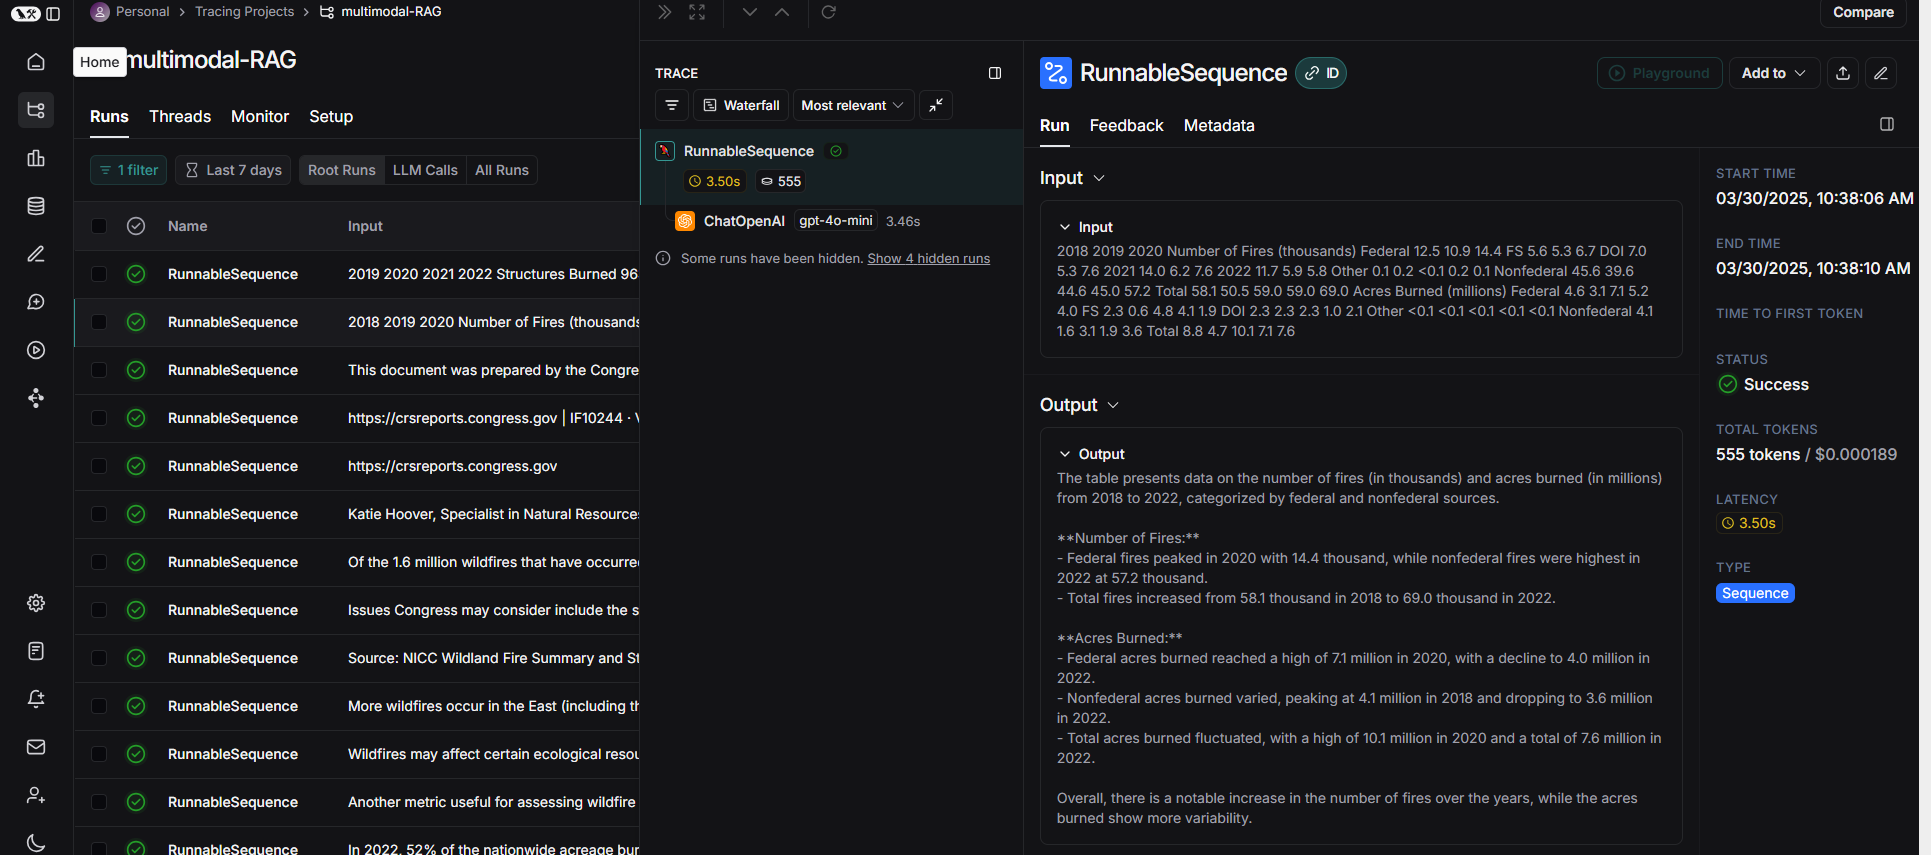

In [16]:
print(len(table_summaries))
print(table_summaries[1])

2
The table shows the number of structures burned from 2019 to 2022, with a significant increase in 2020 (17,904 structures). The number of structures burned decreased in 2021 (5,972) and 2022 (2,717). The percentage of residences affected varied, peaking at 60% in 2021 and dropping to 46% in 2019 and 2022.


## Image summaries
We will use gpt-4o to produce the image summaries.
Option 3.

* We will use Unstructured to parse images, text, and tables from documents (PDFs).
* We will use the multi-vector retriever with Chroma to store raw text and images along with their summaries for retrieval.
* We will use gpt-4o for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).

[Reference - Langchain - https://blog.langchain.dev/semi-structured-multi-modal-rag/]

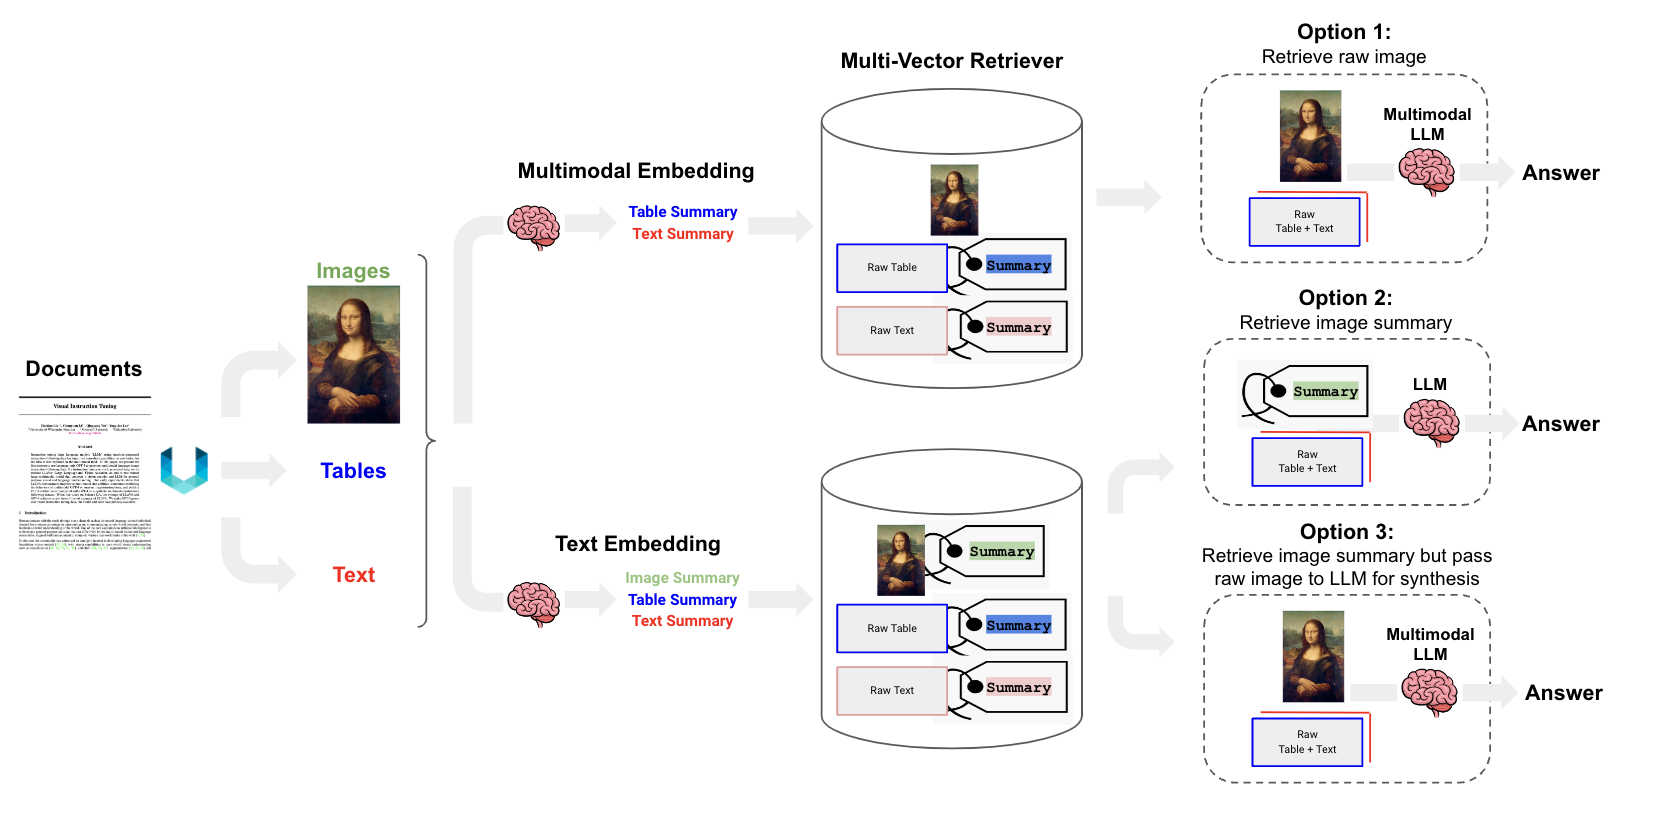

In [17]:
import os
img_output_dir = "Documents/multimodal_output/wildfire/"
# List all extracted images
extracted_files = os.listdir(img_output_dir)
print("Extracted images:", extracted_files)

Extracted images: ['image_0.png', 'image_1.png', 'image_2.png', 'image_3.png', 'image_4.png']


In [19]:
import base64

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        img_bytes = image_file.read()
        img = Image.open(io.BytesIO(img_bytes))
        img_format = img.format.lower()
        return base64.b64encode(img_bytes).decode("utf-8"), img_format


def image_summarize(img_base64, prompt, image_format):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/{image_format};base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    """

    # base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(path, img_file)
            base64_image, img_format = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt, img_format))

    return img_base64_list, image_summaries


# Image summarization 
img_base64_list, image_summaries = generate_img_summaries(img_output_dir)
print(len(img_base64_list))
print(len(img_base64_list[3]))

5
14452


### Passing Images to LLM
- encode_image(..) : """Getting the base64 string"""
- image_summarize(img_base64, prompt):  """Make image summary"""
- generate_img_summaries(path): Generate summaries and base64 encoded strings for images

> Got error when running above image-summarize code:

NotFoundError: Error code: 404 - {'error': {'message': 'The model `gpt-4-vision-preview` has been deprecated, learn more here: https://platform.openai.com/docs/deprecations', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In Langsmith: 
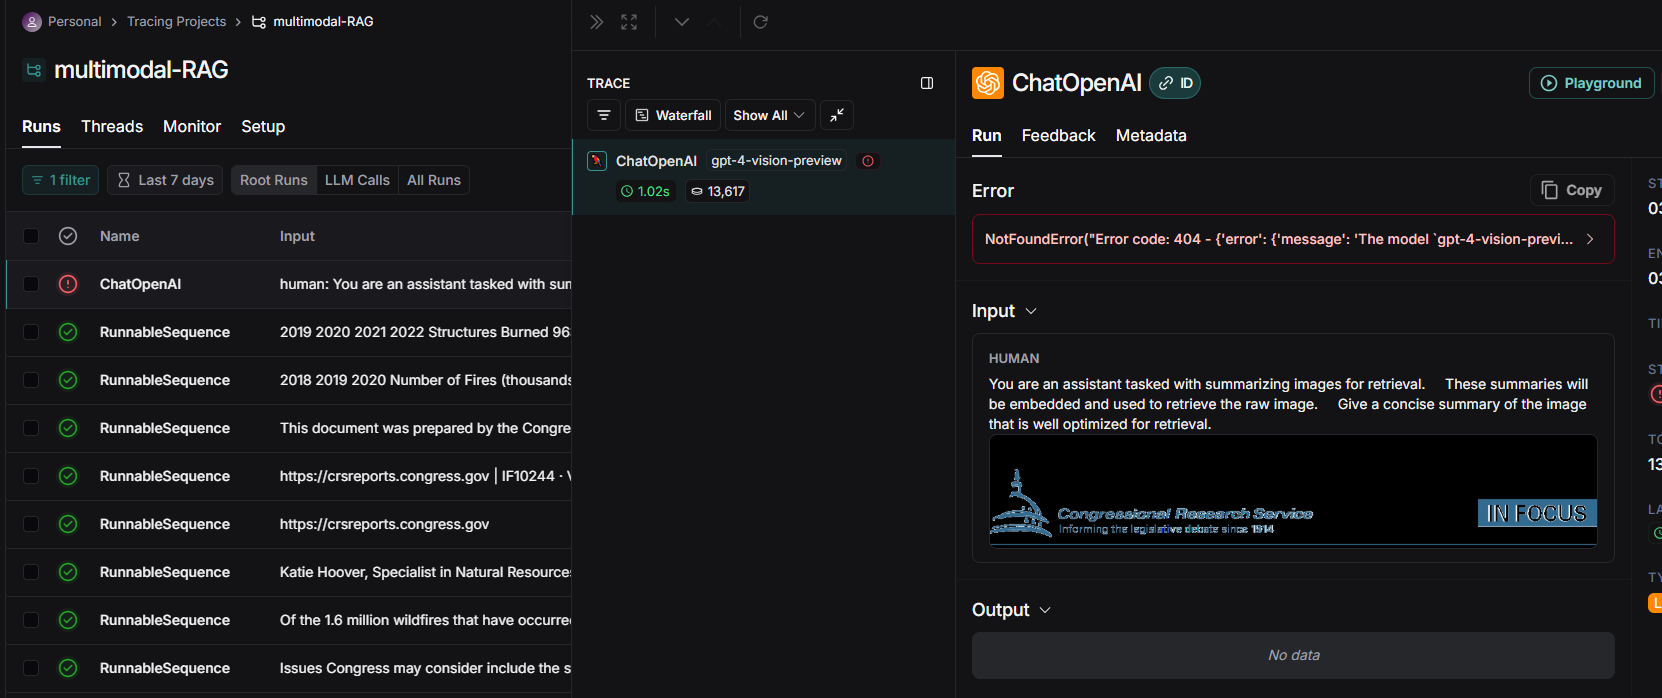

Successful Image summarize:
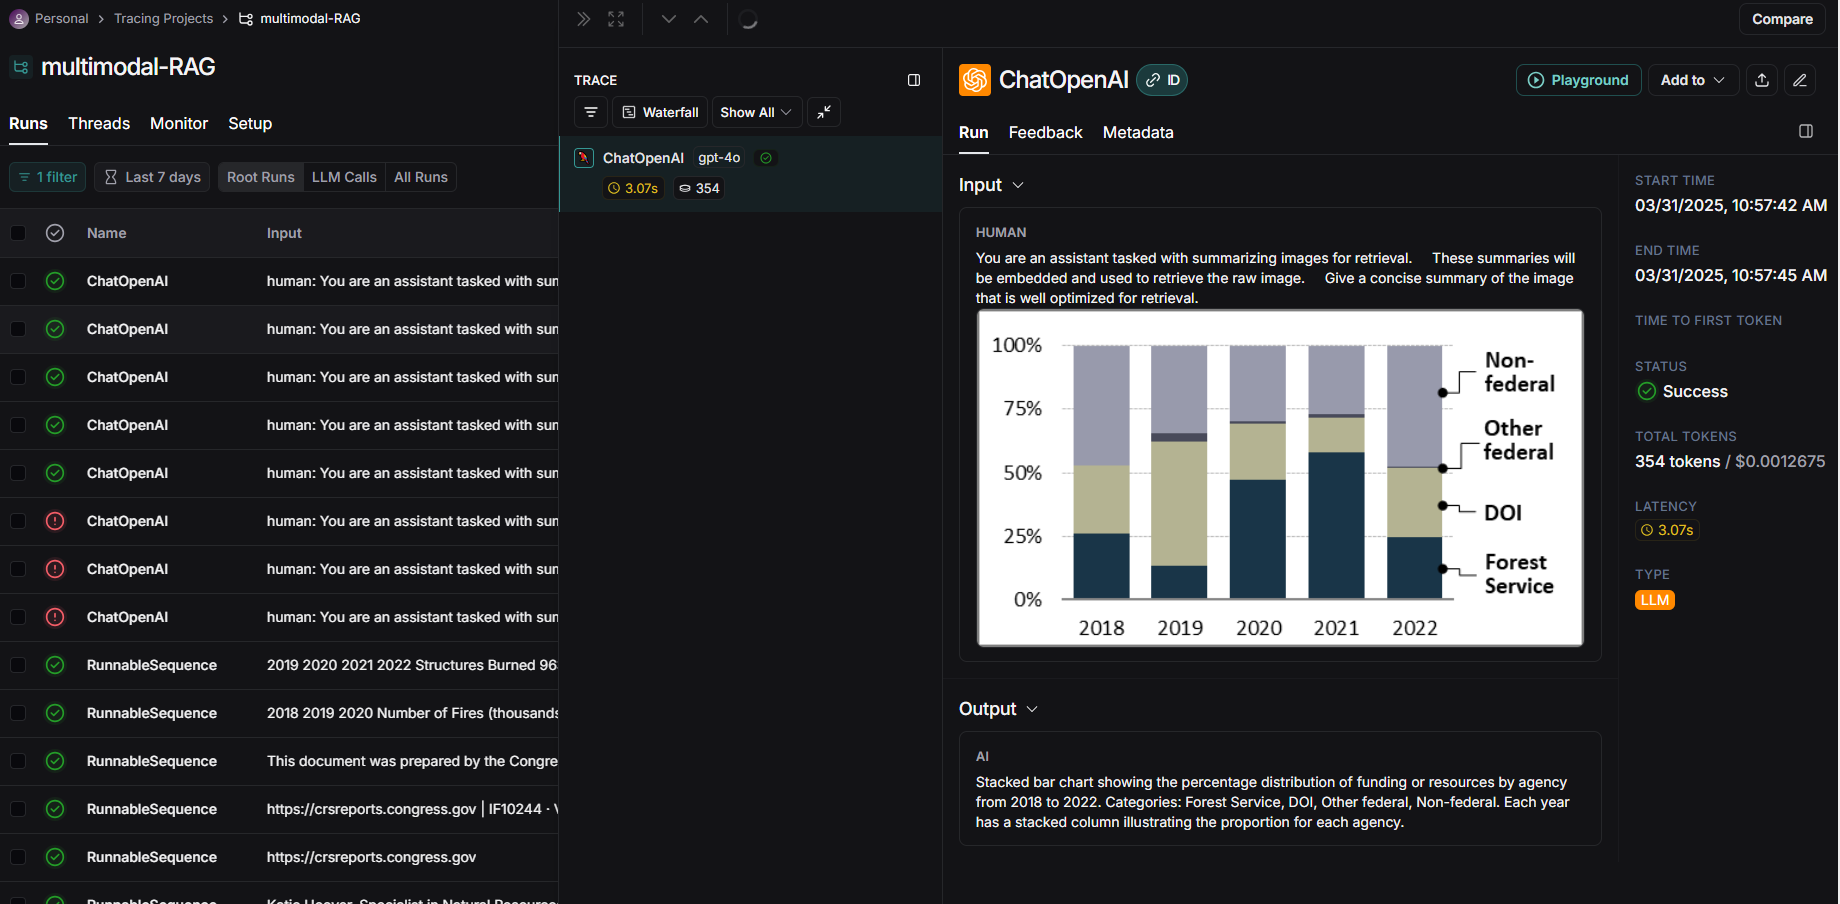

In [20]:
print("image_summaries : ")
print(image_summaries[3])
print("base64_image from img_base64_list : ")
print(len(img_base64_list[3]))
print(img_base64_list[3])

image_summaries : 
Bar chart from 2018 to 2022, showing percentage distribution among Forest Service, DOI, Other Federal, and Non-federal categories. Forest Service and DOI have variable shares across years with notable shifts, while Other Federal and Non-federal categories show more consistent proportions.
base64_image from img_base64_list : 
14452
iVBORw0KGgoAAAANSUhEUgAAAf0AAAEbCAYAAADQ0V0XAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAqCUlEQVR4nO2dT4gc2X3HFScWays4UkzsMfFsnA04A8vEiiY5JUEKaDO2WYEIsSE2A0Ik3thBoCzE0SALr7Nmd4gnUaKLTIgOOwbrks0cFFhdhsHsQexpfBDMbQfmsAO6DDqIPehQya/h9bx+8+pPd7+q77defz/wDtNdXd2/79S3vvVevao68YMf/KD44Q9/qKampqamppZxu3XrVnEC/SPU1NTU1NTUumnD0BdCCCFEnij0hRBCiBlBoS+EEELMCAp9IYQQYkZQ6AshhBAzgkJfCCGEmBEU+kIIIcSMoNAXQgghZgSFvhBCCDEjKPSFEEKIGUGhL4QQQswICn0hhBBiRlDoCyGEEDOCQl8IIYSYERT6QgghxIyg0BdCCCFmBIW+EEIIMSMo9IUQQogZQaEvhBBCzAgKfSGEEGJGUOgLIYQQM4JCXwghhJgRkoT+8+fPi0uXLhUnTpwo7t+/H13m448/Ll588cXBMq6FyzZZ5v333x++d+rUqeLJkyfR36IDGCGEEGKUqUPfD+Gy0P/www+LM2fOjKz/3r17I8s3WcYdFLi/X3/99eLy

### Now we are adding to vectorStore

- Multi Vector Retriever
- For raw texts, tables, and images => docstore
- For summarized table and images including text => vectorstore

In [21]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id_unique"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=store,id_key=id_key)

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        #for raw items - uuid.uuid4() ensures they’re unique
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents] 
        #for summarized items 
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]}) 
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries/table_summaries/image_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(collection_name="mm_rag_wildfire", embedding_function=OpenAIEmbeddings(), persist_directory="./multimodal_output/chroma_db")

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list)

#### MultiVectorRetriever:
Combines two things:
1. A vectorstore (where you store chunks/embeddings for retrieval).
2. A docstore (where you store the actual full documents).

It allows you to retrieve the most relevant chunks, but then return the original full document using the id_key.

#### add_documents()
* 

In [36]:
print(retriever_multi_vector_img)
print("=" * 50)
print(f"Number of vectors in the Chroma vectorstore: {len(retriever_multi_vector_img.vectorstore.get()['documents'])}")
print("=" * 50)
# Print metadata or content of a few sample documents
for i, doc in enumerate(retriever_multi_vector_img.vectorstore.similarity_search("How many acres burned in 2017 and number of fires?", k=3)):
    print(f"Result {i+1}:")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")
    print("-" * 50)


vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000201957E1360> docstore=<langchain_core.stores.InMemoryStore object at 0x00000201E6AAA0B0> id_key='doc_id_unique' search_kwargs={}
Number of vectors in the Chroma vectorstore: 27
Result 1:
Content: Bar chart comparing acres burned (in millions) and number of fires from 2006 to 2020. Data for years: 2006, 2007, 2015, 2017, and 2020. Key figures: 2015 (10.13 million acres, 68.2 fires), 2020 (10.12, 59.0), 2017 (10.03, 71.5), 2006 (9.87, 96.4), 2007 (9.33, 67.8).
Metadata: {'doc_id_unique': 'cbefcb4c-cbfc-4d2a-9786-11e5dd8c27ce'}
--------------------------------------------------
Result 2:
Content: From 2013 to 2022, there was an average of 61,410 wildfires each year, affecting about 7.2 million acres annually. In 2022, there were 68,988 wildfires that burned 7.6 million acres, with over 40% (3.1 million acres) occurring in Alaska.
Metadata: {'doc_id_unique': '5a81e1d6-6b35-46c2-bb42-6e9630de3494'}
--------------------------

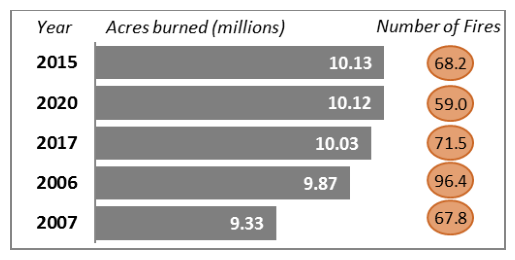

In [38]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the image with PIL
img = Image.open(img_output_dir + 'image_2.png')

# Display the image inline using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide axis for better image display
plt.show()



### Now implementing RAG 
#### Building retriever


In [53]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide accurate answer to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

### Testing

In [59]:
# Check retrieval
query = "How many acres burned in 2017 and number of fires?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

print(type(docs))
print(docs)

for i, doc in enumerate(docs):
    print(f"--- Document {i+1} ---")
    print(doc)  # just print the string
    print()


<class 'list'>
['iVBORw0KGgoAAAANSUhEUgAAAgAAAAD4CAYAAACaJl6nAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAyg0lEQVR4nO2df4hdV/nuA9ooDlLylev1ixAvUrggKnFKKPYWStVoJI5MIVQt31KwJdze2kanRUKKRqeZMCFm9Bq1qXGK/WeGIrR/mD8GioQYLA29nSZNmh+NmWaasWrSBtNmnDIx7Jtnp+92nTVrrb32+bHW2uc8H3iwnrPPj9nZZ7/Pete73rVs69at2bZt2yiKoiiK6hGNjIxky2J/CYqiKIqiwqswAIQQQgjpfmgACCGEkB6EBoAQQgjpQWgACCGEkB6EBoAQQgjpQWgACCGEkB6EBoAQQgjpQWgACCGEkB6EBoAQQkhSDA0NZX19fdm5c+difxUrBw4cyJYtW5Yr9e9qgwaAdJQ6/JCrMDMzk61YsSLbsmWL87iFhYVs5cqVpce1iun8pnjOQ50P4g+uEwSv/v7+bH5+3vi87blOItdKjM/2xfc+AOQ861L/PjlmcnKyw9+8kWgGoOwfGSdk+fLl2cGDB4N9p5S5fPlyNjAwkF8kdbmJ1uGHXBVx/WU/1E4EYf0mYTq/tnMe6wajgu8wODgY7fPJv5HrBNeE6T4b07BVCa6x8P19y33bdQ+UY2KY9qgZAFuQl5tsyhdAaNR0U11uonX4IVdlfHy81Jh24u823SRMn2N6LOYNRiXFzESvItfJt771LeO1Ks/HMIy+JjsWYo587sNyHlO9Z0c1ALiZ6v/QcsK6adTYKnID/9rXvlbqJlMi9R9yM/gEsVCBznR+Uz7nPuaJhAHXCf4t/vSnPxnvKfJ8jH+r1K+TKgY/9cFsVAOgu6NURiqpof4g6jSKSv2HXBW5Pl1uPmTWw3R+Uz7nKX+3XgP/FnIfsV1HptoS3SiYpgpkqkedZlBNqQz8bMVzco97/vnn89+SHGv6TemfYTpOvo+aRbUZZPUYfXp


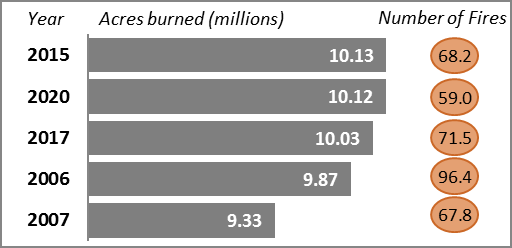

None


In [65]:
print(plt_img_base64(docs[0]))


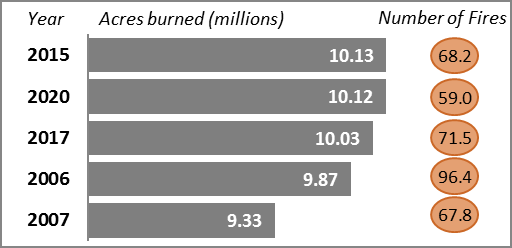

Bar chart comparing acres burned (in millions) and number of fires from 2006 to 2020. Data for years: 2006, 2007, 2015, 2017, and 2020. Key figures: 2015 (10.13 million acres, 68.2 fires), 2020 (10.12, 59.0), 2017 (10.03, 71.5), 2006 (9.87, 96.4), 2007 (9.33, 67.8).


In [51]:
plt_img_base64(img_base64_list[2])
print(image_summaries[2])

### Running RAG

In [55]:
chain_multimodal_rag.invoke(query)

'In 2017, 10.03 million acres burned, and there were 71,500 fires.'

### Flow from LangSmith how we got the final answer
RunnanleSequence
1. map:key:context
* MultiVectorRetriever
* split_image_text_types
2. img_prompt_fun
3. ChatOpenAI - gpt-4o
  

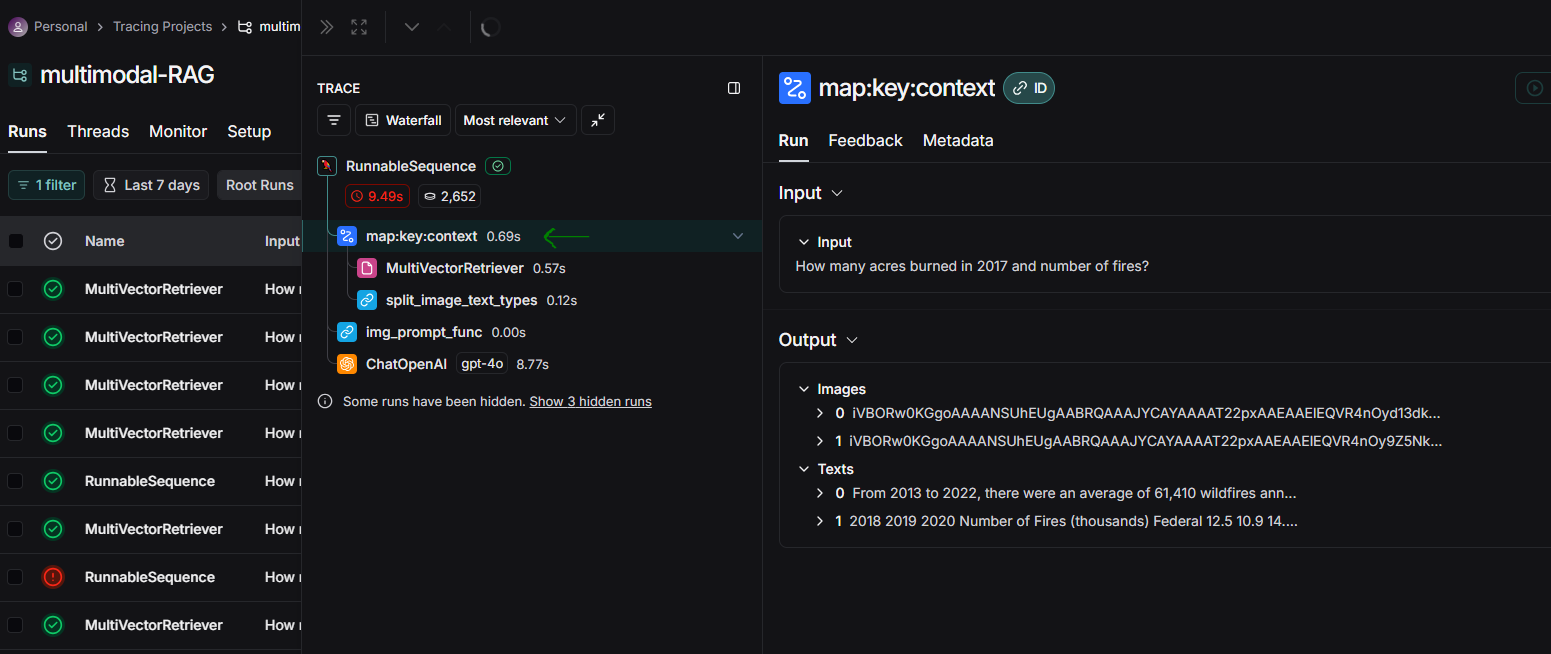
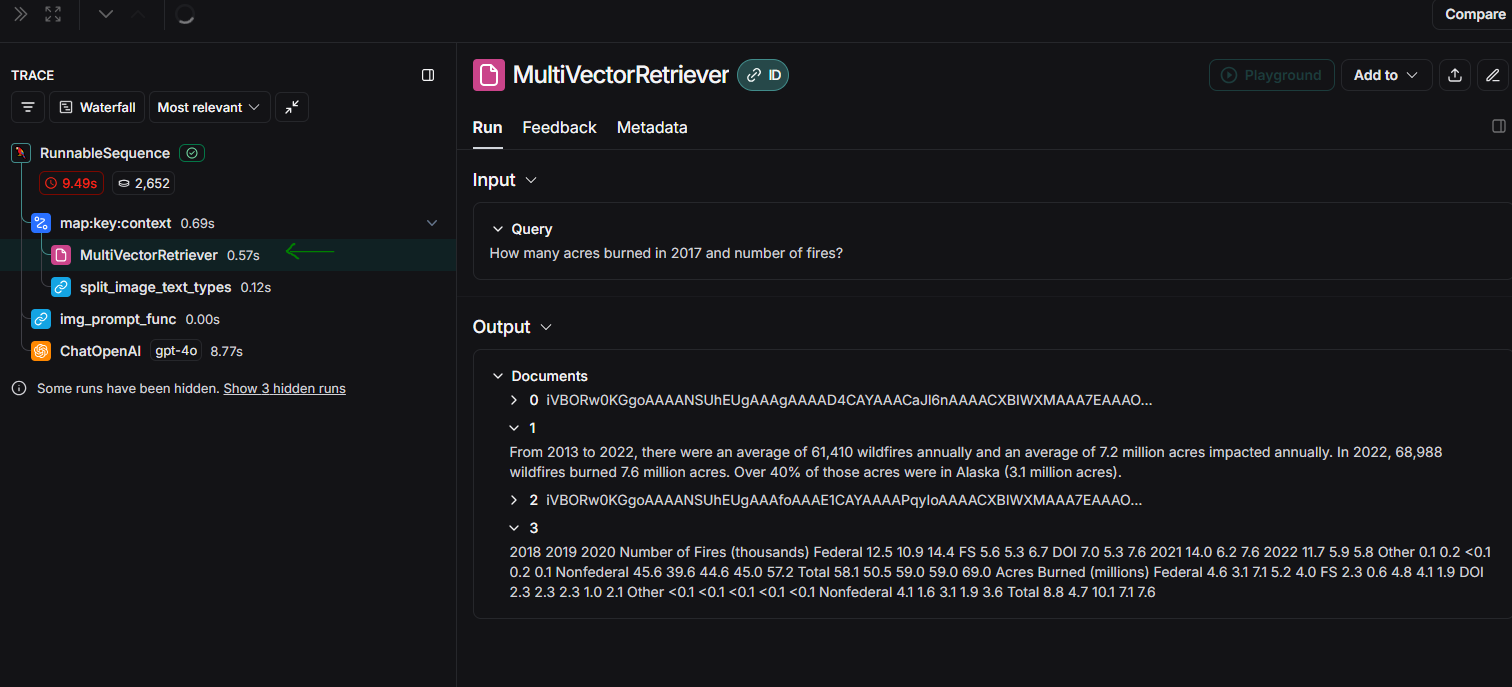
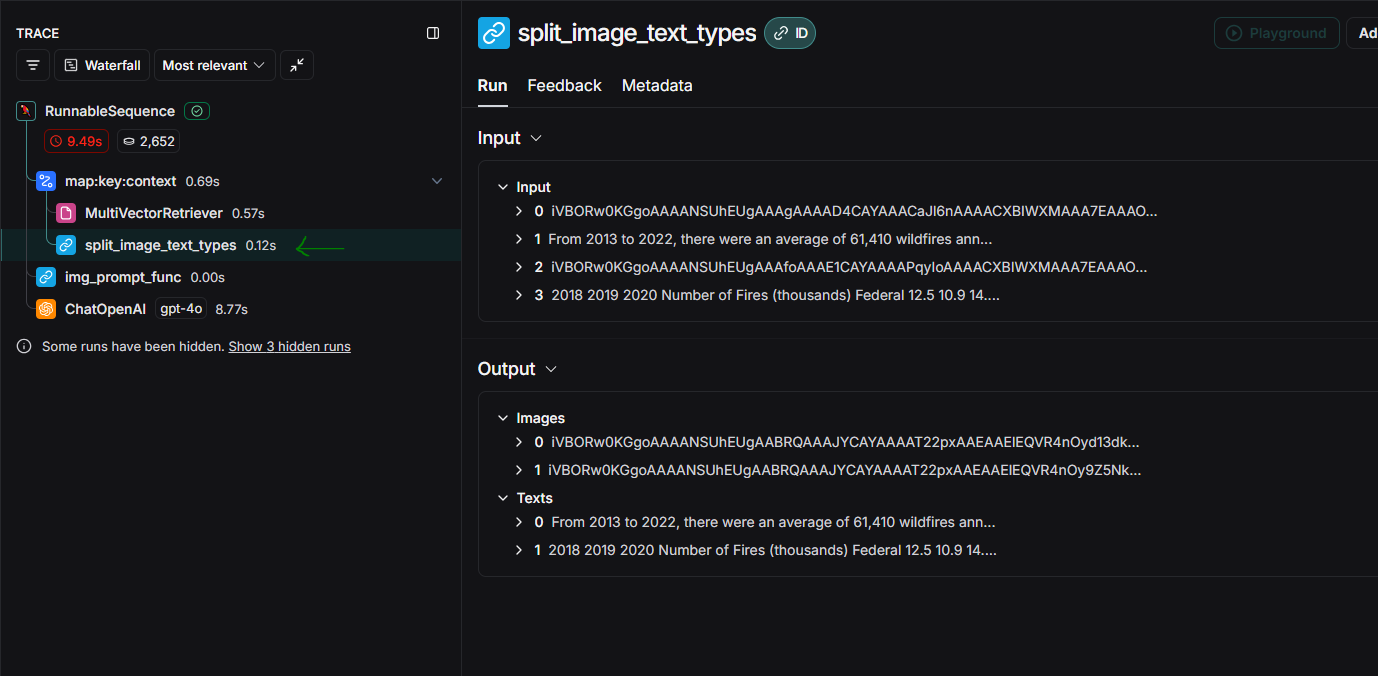
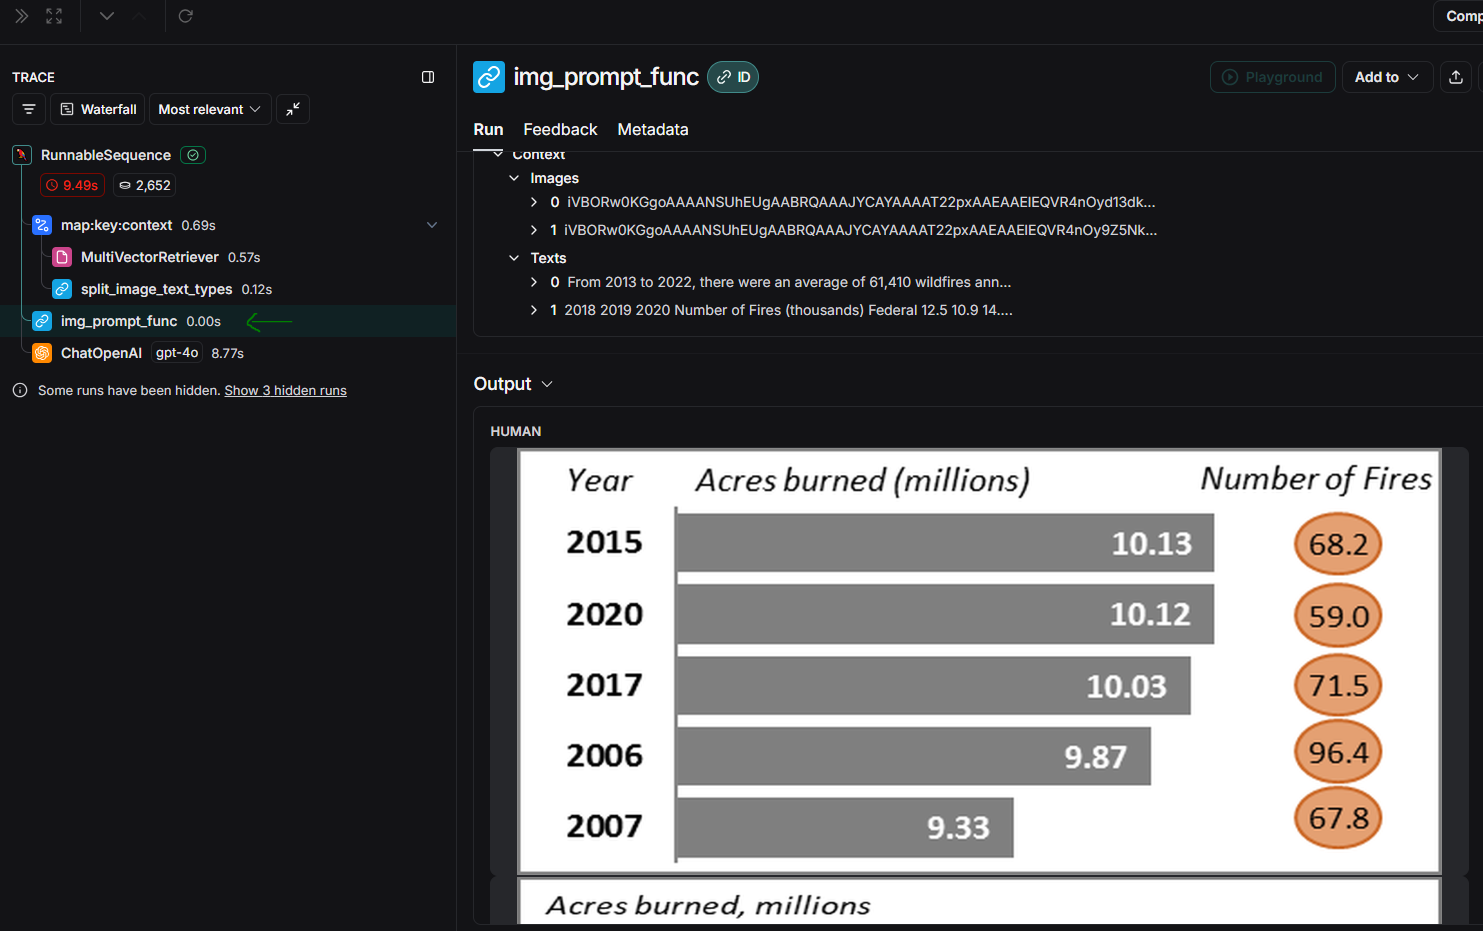
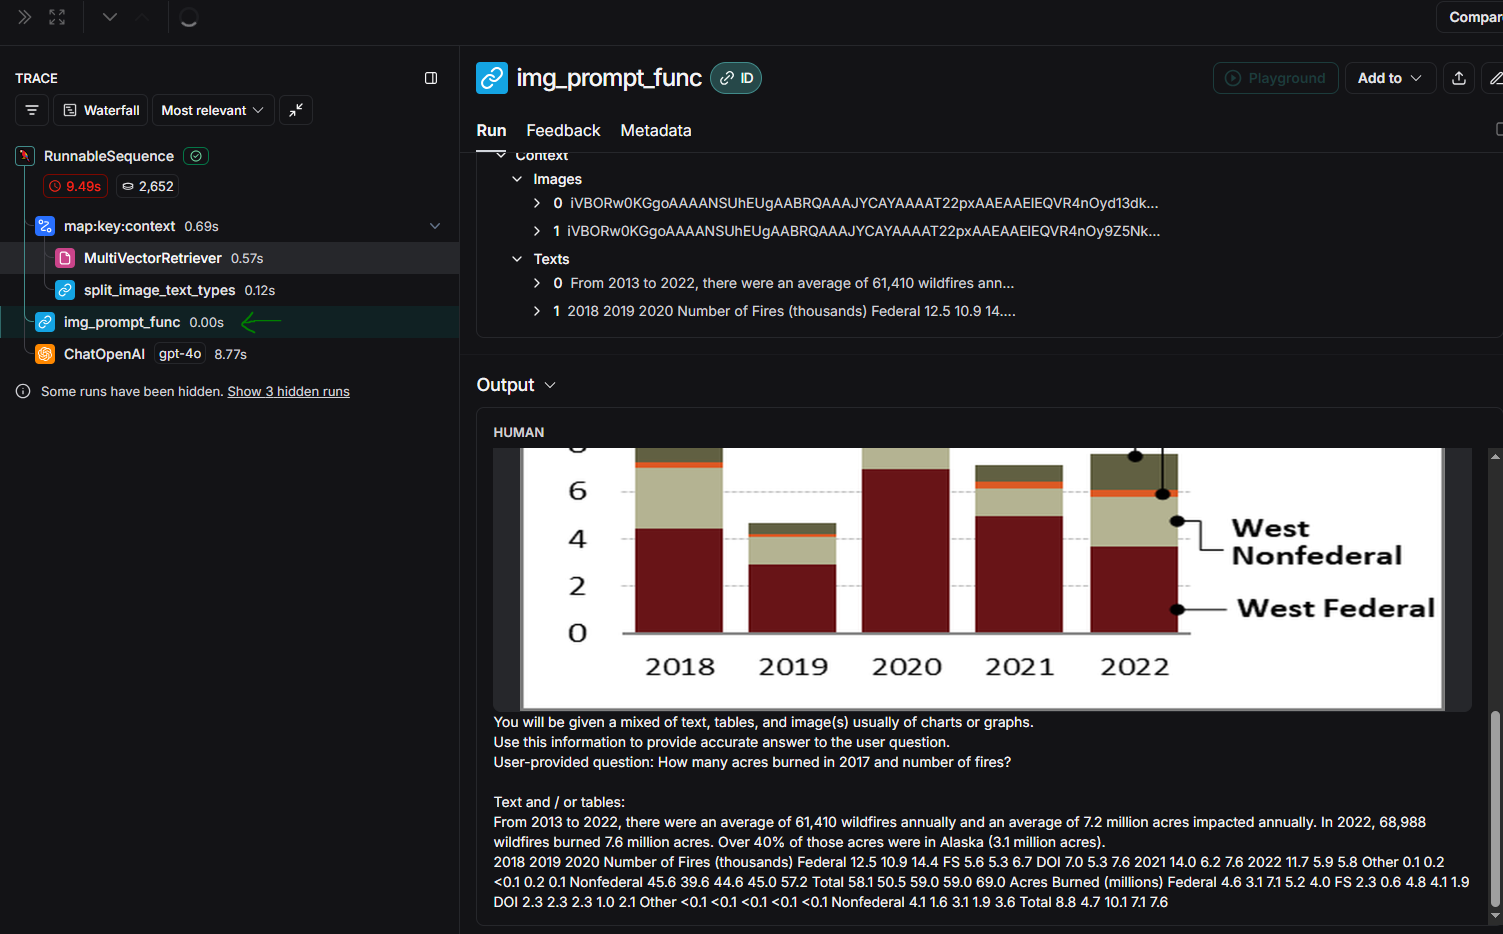
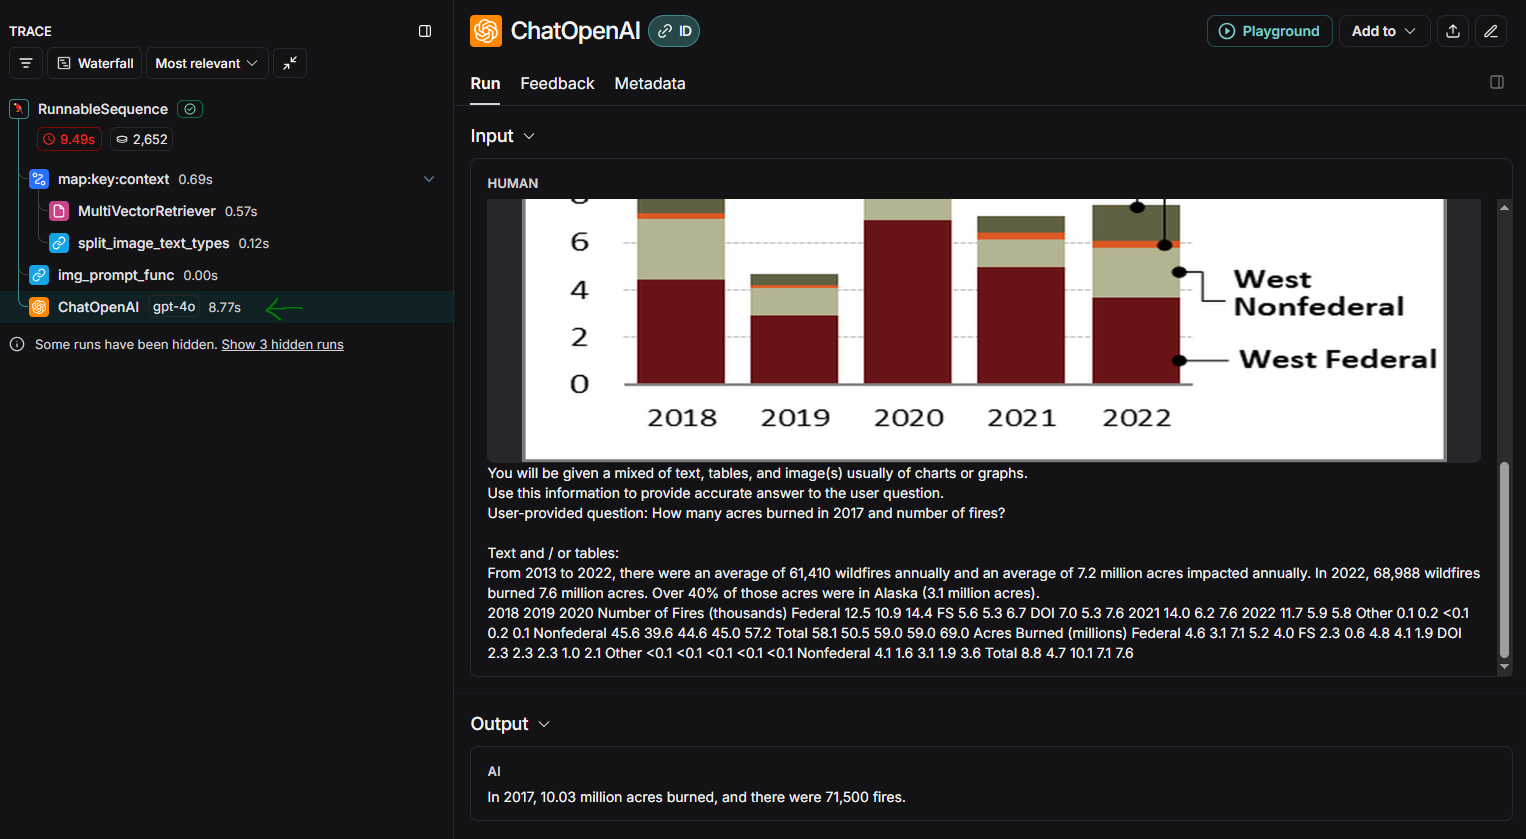

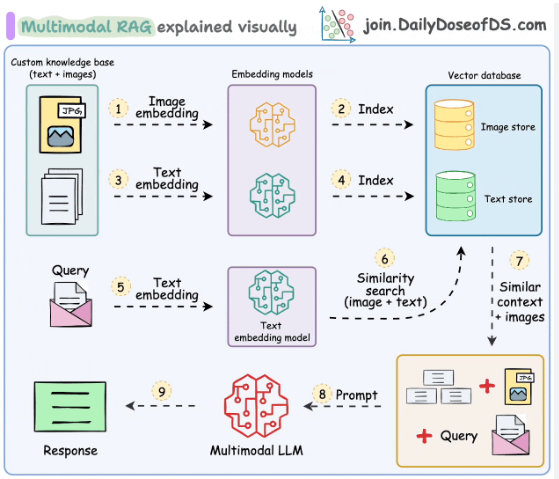